# Import necessary libraries

In [1]:
%pip install scikit-learn
!pip install category_encoders
import pandas as pd
from scipy.stats import f_oneway
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OneHotEncoder
from tensorflow.keras.models import Sequential

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.7 MB/s eta 0:00:00


# Read the data into a DataFrame

In [2]:
# Replace 'your_file.csv' with the actual filename
file_path = '/content/HCCUR2021_National_Demographic.csv'

In [3]:
data = pd.read_csv(file_path)

In [4]:
# Display the first few rows of the DataFrame to understand the structure
data.head()

,yr,age_band_cd,sex,hcci_detcat_1,hcci_detcat_2,hcci_detcat_3,hcci_detcat_1_label,hcci_detcat_2_label,hcci_detcat_3_label,spend_per_person,oop_per_person,util_per_1000,price,oop_price
0,2017,01,All,IP,00,All,Inpatient,Pre MDC/Other transplant,All,57.805378,0.328005,0.400184,144446.970,819.63544
1,2017,01,All,IP,00,S,Inpatient,Pre MDC/Other transplant,Surgical,17.767666,0.195891,0.319574,55597.957,612.97607
2,2017,01,All,IP,00,T,Inpatient,Pre MDC/Other transplant,Transplant,40.037712,0.132114,0.080610,496684.090,1638.92550
3,2017,01,All,IP,01,All,Inpatient,Nervous System,All,48.698692,1.140857,1.479640,32912.531,771.03668
4,2017,01,All,IP,01,M,Inpatient,Nervous System,Medical,26.288654,0.971765,1.163726,22590.066,835.04639


In [5]:
data = data.dropna()
data['oop_price'] = data['oop_price'].astype(int)
data['price'] = data['price'].astype(int)

In [6]:
# Filter rows for the year 2021
test_val_data = data[data['yr'] == 2021]

In [7]:
# Remove rows for the year 2021 from the original DataFrame
data = data[data['yr'] != 2021]

In [8]:
# Display the first few rows of the test data DataFrame
test_val_data.head()

,yr,age_band_cd,sex,hcci_detcat_1,hcci_detcat_2,hcci_detcat_3,hcci_detcat_1_label,hcci_detcat_2_label,hcci_detcat_3_label,spend_per_person,oop_per_person,util_per_1000,price,oop_price
22747,2021,01,All,IP,00,All,Inpatient,Pre MDC/Other transplant,All,66.943848,0.358397,0.625120,107089,573
22748,2021,01,All,IP,00,S,Inpatient,Pre MDC/Other transplant,Surgical,22.818331,0.347998,0.553905,41195,628
22749,2021,01,All,IP,00,T,Inpatient,Pre MDC/Other transplant,Transplant,44.125519,0.010399,0.071215,619611,146
22750,2021,01,All,IP,01,All,Inpatient,Nervous System,All,53.644474,1.072147,1.306712,41053,820
22751,2021,01,All,IP,01,M,Inpatient,Nervous System,Medical,25.060486,0.911534,0.987042,25389,923


In [9]:
# Assuming 'data' is the DataFrame containing your data
unique_years = data['yr'].unique()
unique_years

array([2017, 2018, 2019, 2020])

# Hypothesis 1: Is there a significant difference in out-of-pocket spending between different health care patient categories?

In [10]:
# Group data by health care categories and calculate mean oop_per_person
healthcare_categories = data.groupby('hcci_detcat_1')['oop_per_person'].mean()

# Perform one-way ANOVA to test for significant differences in oop_per_person among categories
f_stat, p_value = f_oneway(*[group['oop_per_person'] for name, group in data.groupby('hcci_detcat_1')])

print("Hypothesis 1: Is there a significant difference in out-of-pocket spending between different health care categories?")
print(f"ANOVA F-statistic: {f_stat}")
print(f"P-value: {p_value}")
if p_value < 0.05:
    print("Conclusion: There is a significant difference in out-of-pocket spending among health care categories.")
else:
    print("Conclusion: There is no significant difference in out-of-pocket spending among health care categories.")

Hypothesis 1: Is there a significant difference in out-of-pocket spending between different health care categories?
ANOVA F-statistic: 210.00664952958343
P-value: 2.2382258010103047e-134
Conclusion: There is a significant difference in out-of-pocket spending among health care categories.


In [11]:
healthcare_categories

hcci_detcat_1
IP     1.704538
OP     7.412608
PH    13.948667
RX    19.562136
Name: oop_per_person, dtype: float64

# Hypothesis 2: Do surgical procedures have higher average prices compared to medical procedures?

In [12]:
# Calculate mean prices for surgical and medical procedures
surgical_mean_price = data[data['hcci_detcat_3'] == 'S']['price'].mean()
medical_mean_price = data[data['hcci_detcat_3'] == 'M']['price'].mean()

# Check for NaN values in medical mean price and handle them
if pd.isna(medical_mean_price):
    # There might be NaN values, so excluding NaNs and calculating mean again
    medical_mean_price = data[data['hcci_detcat_3'] == 'M']['price'].dropna().mean()

print("Hypothesis 2: Do surgical procedures have higher average prices compared to medical procedures?")
print(f"Mean price of surgical procedures: {surgical_mean_price}")
print(f"Mean price of medical procedures: {medical_mean_price}")
if surgical_mean_price > medical_mean_price:
    print("Conclusion: Surgical procedures have a higher average price compared to medical procedures.")
else:
    print("Conclusion: There's no clear evidence that surgical procedures have a higher average price compared to medical procedures.")

Hypothesis 2: Do surgical procedures have higher average prices compared to medical procedures?
Mean price of surgical procedures: 49283.057800224466
Mean price of medical procedures: 22711.838377723972
Conclusion: Surgical procedures have a higher average price compared to medical procedures.


# Hypothesis 3: Is there a difference in utilization rates between genders in nervous system-related cases?

In [13]:
nervous_system_data = data[data['hcci_detcat_2_label'] == 'Nervous System']
gender_utilization = nervous_system_data.groupby('sex')['util_per_1000'].mean()

print("Hypothesis 3: Is there a difference in utilization rates between genders in nervous system-related cases?")
print(gender_utilization)
# Analyze the difference in utilization rates between genders in nervous system-related cases visually or statistically
print("Conclusion : There is a difference in utilization rates between genders in nervous system-related cases")

Hypothesis 3: Is there a difference in utilization rates between genders in nervous system-related cases?
sex
All    1.524580
F      1.501635
M      1.559680
Name: util_per_1000, dtype: float64
Conclusion : There is a difference in utilization rates between genders in nervous system-related cases


In [14]:
nervous_system_data.head()

,yr,age_band_cd,sex,hcci_detcat_1,hcci_detcat_2,hcci_detcat_3,hcci_detcat_1_label,hcci_detcat_2_label,hcci_detcat_3_label,spend_per_person,oop_per_person,util_per_1000,price,oop_price
3,2017,01,All,IP,01,All,Inpatient,Nervous System,All,48.698692,1.140857,1.479640,32912,771
4,2017,01,All,IP,01,M,Inpatient,Nervous System,Medical,26.288654,0.971765,1.163726,22590,835
5,2017,01,All,IP,01,S,Inpatient,Nervous System,Surgical,22.410038,0.169091,0.315914,70937,535
282,2017,01,F,IP,01,All,Inpatient,Nervous System,All,48.014973,1.135247,1.453605,33031,780
283,2017,01,F,IP,01,M,Inpatient,Nervous System,Medical,26.222420,0.978277,1.139601,23010,858


# Hypothesis 4: Are there significant differences in utilization rates across different years?

In [15]:
# Perform one-way ANOVA to test for significant differences in utilization rates among years
f_stat_util, p_value_util = f_oneway(*[group['util_per_1000'] for name, group in data.groupby('yr')])

print("Hypothesis 4: Are there significant differences in utilization rates across different years?")
print(f"ANOVA F-statistic for utilization rates: {f_stat_util}")
print(f"P-value for utilization rates: {p_value_util}")
if p_value_util < 0.05:
    print("Conclusion: There are significant differences in utilization rates across different years.")
else:
    print("Conclusion: There are no significant differences in utilization rates across different years.")

Hypothesis 4: Are there significant differences in utilization rates across different years?
ANOVA F-statistic for utilization rates: 0.06733901548486773
P-value for utilization rates: 0.9772624480878692
Conclusion: There are no significant differences in utilization rates across different years.


# Visualisation

## 1. Histogram of Out-of-Pocket Spending

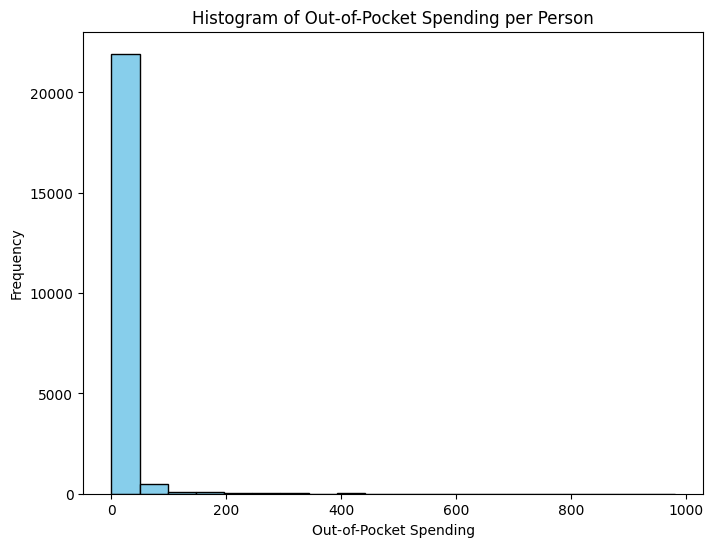

In [16]:
# 'oop_per_person' represents out-of-pocket spending per person
plt.figure(figsize=(8, 6))
plt.hist(data['oop_per_person'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Out-of-Pocket Spending per Person')
plt.xlabel('Out-of-Pocket Spending')
plt.ylabel('Frequency')
plt.show()

## 2. Boxplot of Utilization Rates by Health Care Categories

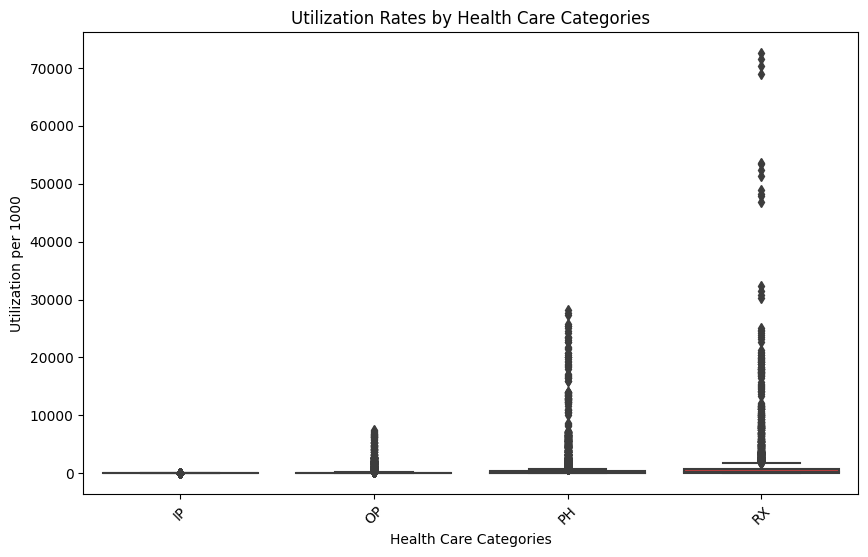

In [17]:
# 'util_per_1000' represents utilization per 1000 people
# 'hcci_detcat_1' represents the health care categories
plt.figure(figsize=(10, 6))
sns.boxplot(x='hcci_detcat_1', y='util_per_1000', data=data)
plt.title('Utilization Rates by Health Care Categories')
plt.xlabel('Health Care Categories')
plt.ylabel('Utilization per 1000')
plt.xticks(rotation=45)
plt.show()

## 3. Line Plot of Price Trends Over Years

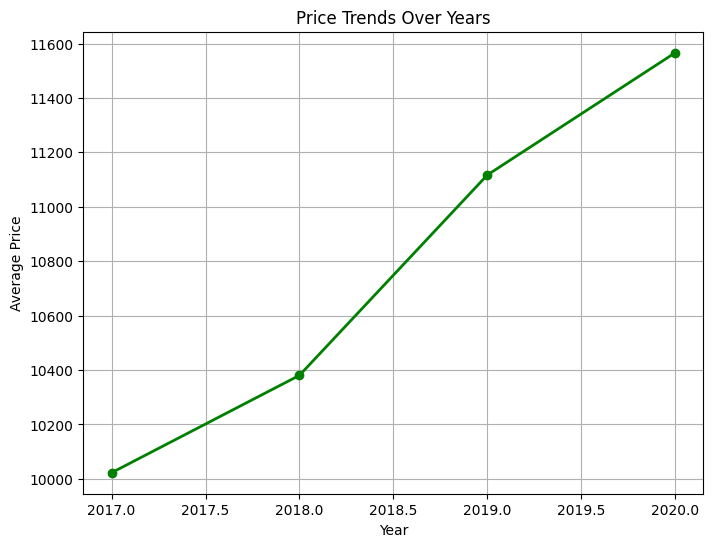

In [18]:
price_trends = data.groupby('yr')['price'].mean()
plt.figure(figsize=(8, 6))
price_trends.plot(marker='o', color='green', linestyle='-', linewidth=2)
plt.title('Price Trends Over Years')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

## 4. Scatterplot Matrix of Spending Metrics

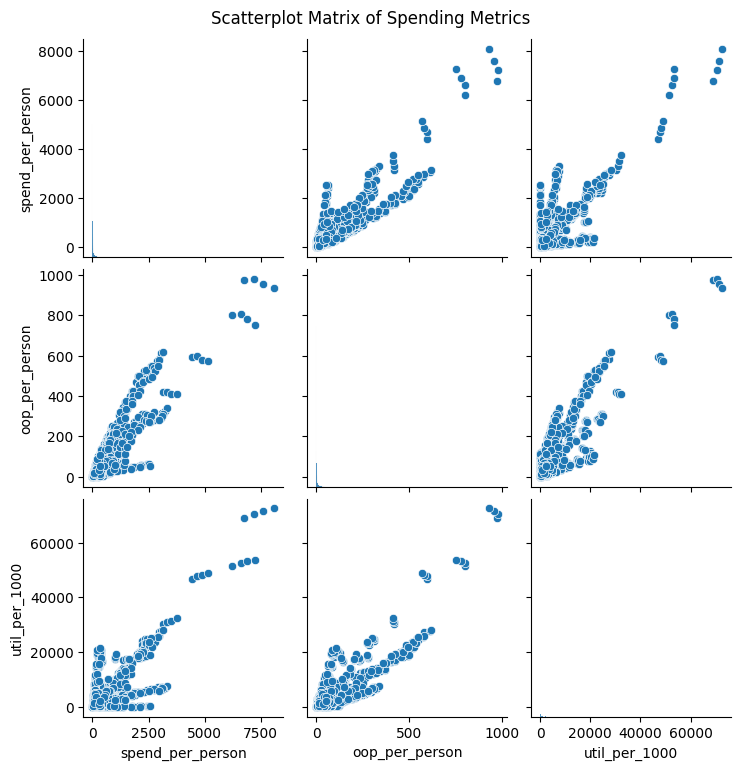

In [19]:
spending_metrics = data[['spend_per_person', 'oop_per_person', 'util_per_1000']]
sns.pairplot(spending_metrics)
plt.suptitle('Scatterplot Matrix of Spending Metrics', y=1.02)
plt.show()

<ipython-input-20-a091f0f4dcb4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


<Axes: >

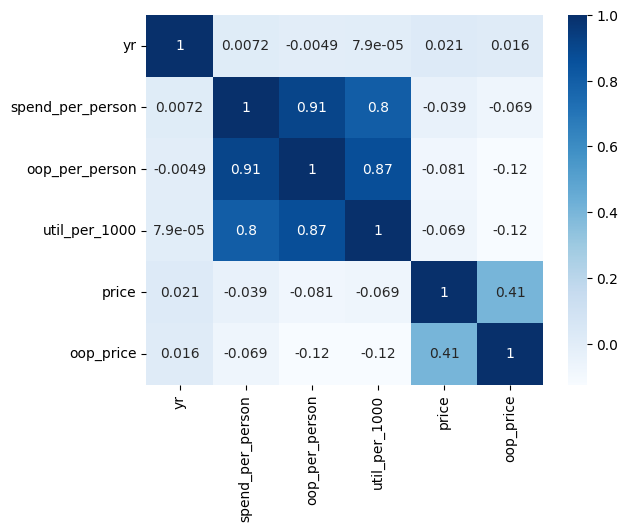

In [20]:
corr = data.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

# Data Pre-Processing

In [20]:
# Remove null and NaN values
data = data.dropna()

In [21]:
# Convert 'oop_price' and 'price' columns to integer values
data['oop_price'] = data['oop_price'].astype(int)
data['price'] = data['price'].astype(int)

In [22]:
# List of categorical columns
categorical_cols = ['age_band_cd', 'sex', 'hcci_detcat_1', 'hcci_detcat_2', 'hcci_detcat_3',
                    'hcci_detcat_1_label', 'hcci_detcat_2_label', 'hcci_detcat_3_label']

In [23]:
# Create a ColumnTransformer to apply one-hot encoding to categorical columns
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), categorical_cols)],
    remainder='passthrough'  # Pass through any remaining columns
)

In [24]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OneHotEncoder(),
                                 ['age_band_cd', 'sex', 'hcci_detcat_1',
                                  'hcci_detcat_2', 'hcci_detcat_3',
                                  'hcci_detcat_1_label', 'hcci_detcat_2_label',
                                  'hcci_detcat_3_label'])])

In [25]:
# Define the features and target variable
features = data.columns.difference(['oop_price'])
X, y = data[features], data['oop_price']
# Apply the transformation to the entire dataset
X_processed = preprocessor.fit_transform(X)

In [26]:
X_processed

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.78053780e+01, 4.00184095e-01, 2.01700000e+03],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.77676659e+01, 3.19574088e-01, 2.01700000e+03],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.00377121e+01, 8.06100145e-02, 2.01700000e+03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.22560883e+01, 1.34793884e+03, 2.02000000e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.85960724e+02, 8.36956360e+02, 2.02000000e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.38216827e+02, 2.18489526e+03, 2.02000000e+03]])

# Split the data into training and test sets

In [27]:
train_data = data[data['yr'].isin([2017, 2018, 2019])]
test_data = data[data['yr'] == 2020]

In [28]:
X_train, y_train = train_data[features], train_data['oop_price']
X_test, y_test = test_data[features], test_data['oop_price']

In [29]:
# Apply the transformation to the training and test data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [30]:
X_train_processed

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.78053780e+01, 4.00184095e-01, 2.01700000e+03],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.77676659e+01, 3.19574088e-01, 2.01700000e+03],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.00377121e+01, 8.06100145e-02, 2.01700000e+03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.71888199e+01, 1.24895947e+03, 2.01900000e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.99508575e+02, 9.39332642e+02, 2.01900000e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.46697388e+02, 2.18829224e+03, 2.01900000e+03]])

# Modelling  (2017-2020)

##  Linear Regression

In [31]:
linear_model = LinearRegression()
linear_model.fit(X_train_processed, y_train)
y_pred_linear = linear_model.predict(X_test_processed)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

In [32]:
linear_model.intercept_

-9181682256.030666

# Evaluated Result of Linear Regression


In [33]:
print("Linear Regression Model:")
print(f"Mean Squared Error: {mse_linear}")
print(f"R-squared Score: {r2_linear}")

Linear Regression Model:
Mean Squared Error: 38970.995643347545
R-squared Score: 0.8107307809013514


## Random Forest Regressor

In [34]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_processed, y_train)
y_pred_rf = rf_model.predict(X_test_processed)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

## Evaluated Result of Random Forest Regressor

In [35]:
print("Random Forest Regressor Model:")
print(f"Mean Squared Error: {mse_rf}")
print(f"R-squared Score: {r2_rf}")

Random Forest Regressor Model:
Mean Squared Error: 14924.992766695881
R-squared Score: 0.9275142531164016


## Support Vector Regressor

In [36]:
svr_model = SVR()
svr_model.fit(X_train_processed, y_train)
y_pred_svr = svr_model.predict(X_test_processed)
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

## Evaluated Result of Support Vector Regressor

In [37]:
print("Support Vector Regressor Model:")
print(f"Mean Squared Error: {mse_svr}")
print(f"R-squared Score: {r2_svr}")

Support Vector Regressor Model:
Mean Squared Error: 74654.68585473143
R-squared Score: 0.6374269155683749


## Visualize predicted vs actual values

Text(0.5, 1.0, 'Support Vector Regressor: Actual vs Predicted for different machine learning models')

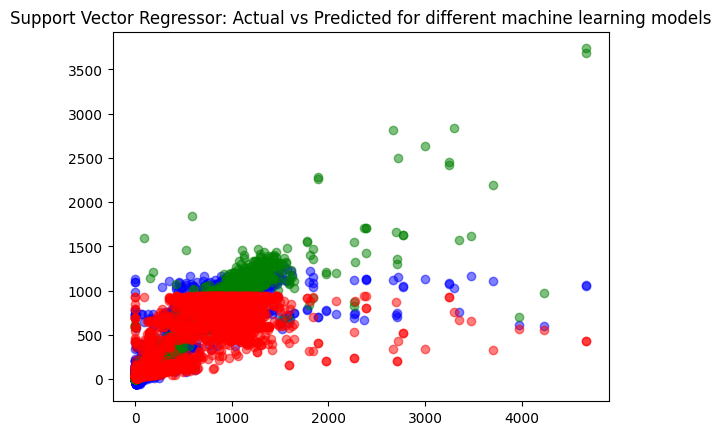

In [38]:

# Linear Regression
graph_7 = plt.scatter(y_test, y_pred_linear, color='blue', alpha=0.5)

# Random Forest Regressor
graph_7 = plt.scatter(y_test, y_pred_rf, color='green', alpha=0.5)

# Support Vector Regressor
graph_7 = plt.scatter(y_test, y_pred_svr, color='red', alpha=0.5)
graph_7 = plt.title('Support Vector Regressor: Actual vs Predicted for different machine learning models')

graph_7

## Comparison of line plot for each model

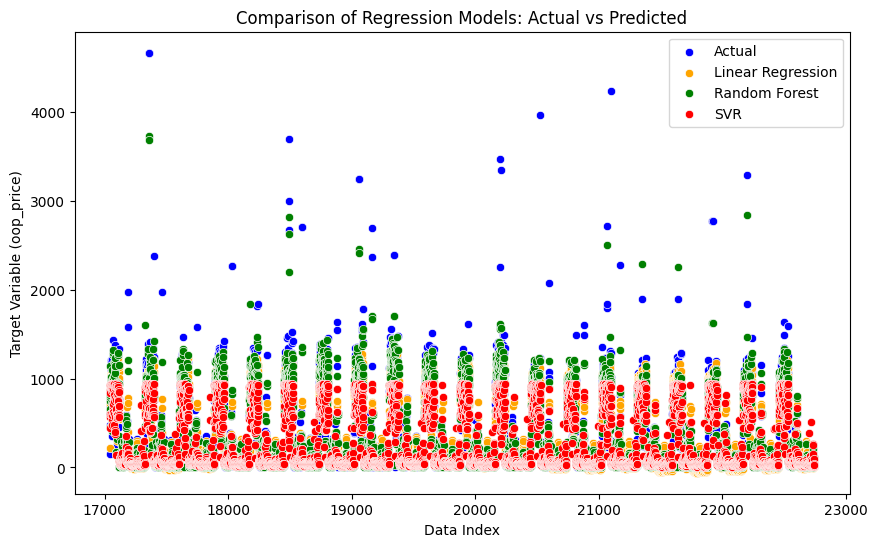

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test.index, y=y_test, label='Actual', color='blue')
sns.scatterplot(x=y_test.index, y=y_pred_linear, label='Linear Regression', color='orange')
sns.scatterplot(x=y_test.index, y=y_pred_rf, label='Random Forest', color='green')
sns.scatterplot(x=y_test.index, y=y_pred_svr, label='SVR', color='red')
plt.title('Comparison of Regression Models: Actual vs Predicted')
plt.xlabel('Data Index')
plt.ylabel('Target Variable (oop_price)')
plt.legend()
plt.show()

In [40]:
y_test

17042    610
17043    690
17044    148
17045    744
17046    837
        ... 
22742     77
22743     14
22744     12
22745     42
22746     24
Name: oop_price, Length: 5705, dtype: int64

In [41]:
X_test_df = pd.DataFrame(X_test, columns=['age_band_cd', 'hcci_detcat_1', 'hcci_detcat_1_label', 'hcci_detcat_2',
       'hcci_detcat_2_label', 'hcci_detcat_3', 'hcci_detcat_3_label',
       'oop_per_person', 'price', 'sex', 'spend_per_person', 'util_per_1000',
       'yr'])
# Add y_pred to the DataFrame
X_test_df['y_pred_linear'] = y_pred_linear
X_test_df['y_pred_rf'] = y_pred_rf
X_test_df['y_pred_svr'] = y_pred_svr
X_test_df['y_test_oopprice'] = y_test
X_test_df

,age_band_cd,hcci_detcat_1,hcci_detcat_1_label,hcci_detcat_2,hcci_detcat_2_label,hcci_detcat_3,hcci_detcat_3_label,oop_per_person,price,sex,spend_per_person,util_per_1000,yr,y_pred_linear,y_pred_rf,y_pred_svr,y_test_oopprice
17042,01,IP,Inpatient,00,Pre MDC/Other transplant,All,All,0.287911,113810,All,53.674988,0.471617,2020,642.799799,653.30,570.782930,610
17043,01,IP,Inpatient,00,Pre MDC/Other transplant,S,Surgical,0.277567,39147,All,15.726931,0.401733,2020,738.332930,743.51,867.741242,690
17044,01,IP,Inpatient,00,Pre MDC/Other transplant,T,Transplant,0.010344,543019,All,37.948055,0.069883,2020,217.404118,1139.58,449.486147,148
17045,01,IP,Inpatient,01,Nervous System,All,All,0.854285,41263,All,47.321499,1.146799,2020,796.918152,793.14,838.075809,744
17046,01,IP,Inpatient,01,Nervous System,M,Medical,0.712742,26171,All,22.270285,0.850929,2020,811.555817,820.44,924.298573,837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22742,All,RX,Prescription Drugs,Other,Other,1,Brand,14.919384,1691,M,326.338501,192.872375,2020,80.542599,119.21,97.420099,77
22743,All,RX,Prescription Drugs,Other,Other,All,All,54.794838,136,M,506.383606,3712.372070,2020,27.263315,17.73,20.692845,14
22744,All,RX,Prescription Drugs,Respiratory,Respiratory,0,Generic,17.124922,38,M,52.256088,1347.938843,2020,4.834291,12.44,27.037596,12
22745,All,RX,Prescription Drugs,Respiratory,Respiratory,1,Brand,35.803310,341,M,285.960724,836.956360,2020,84.747828,44.75,41.176503,42


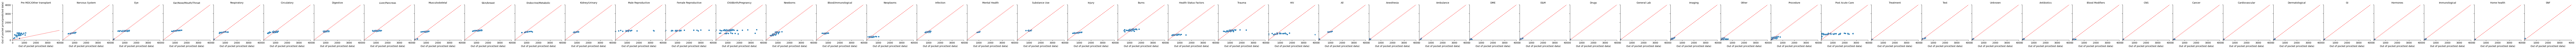

In [42]:
from matplotlib import pyplot as plt
import seaborn as sns
graph_3 = sns.FacetGrid(X_test_df, col = 'hcci_detcat_2_label')
graph_3.map_dataframe(sns.scatterplot,x='y_test_oopprice', y='y_pred_linear')
for ax in graph_3.axes.flat:
    ax.plot([0, ax.get_xlim()[1]], [0, ax.get_ylim()[1]], color='red', linestyle=':', linewidth=2)

    ax.set_xlim([0,4000])
    ax.set_ylim([0,4000])
graph_3.set_axis_labels('Out of pocket price(test data)','Out of pocket price(predicted data)')
graph_3.set_titles(col_template = '{col_name}')

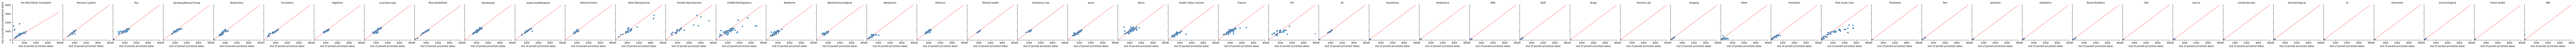

In [43]:
graph_2 = sns.FacetGrid(X_test_df, col = 'hcci_detcat_2_label')
graph_2.map_dataframe(sns.scatterplot,x='y_test_oopprice', y='y_pred_rf')        #click on graphs to zoom the graphs.

for ax in graph_2.axes.flat:
    ax.plot([0, ax.get_xlim()[1]], [0, ax.get_ylim()[1]], color='red', linestyle=':', linewidth=2)

    ax.set_xlim([0,4000])
    ax.set_ylim([0,4000])

graph_2.set_axis_labels('Out of pocket price(test data)','Out of pocket price(predicted data)')
graph_2.set_titles(col_template = '{col_name}')

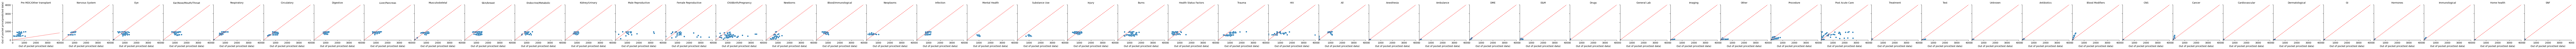

In [44]:
graph_1 = sns.FacetGrid(X_test_df, col = 'hcci_detcat_2_label')
graph_1.map_dataframe(sns.scatterplot,x='y_test_oopprice', y='y_pred_svr')

for ax in graph_1.axes.flat:
    ax.plot([0, ax.get_xlim()[1]], [0, ax.get_ylim()[1]], color='red', linestyle=':', linewidth=2)

    ax.set_xlim([0,4000])
    ax.set_ylim([0,4000])

graph_1.set_axis_labels('Out of pocket price(test data)','Out of pocket price(predicted data)')
graph_1.set_titles(col_template = '{col_name}')

# Evaluation data with 2021 data on neural network

## Separate data for evaluation (2021)

In [54]:
eval_data = test_val_data[test_val_data['yr'] == 2021]

## Define features and target variable

In [55]:
X_eval, y_eval = eval_data[features], eval_data['oop_price']

In [56]:
# Define the categorical columns
categorical_cols = ['age_band_cd', 'sex', 'hcci_detcat_1', 'hcci_detcat_2', 'hcci_detcat_3',
                    'hcci_detcat_1_label', 'hcci_detcat_2_label', 'hcci_detcat_3_label']

# Create a ColumnTransformer with a SparseMatrixCategoricalEncoder for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(use_cat_names=True, handle_unknown='indicator'), categorical_cols),
        ('num', StandardScaler(), X_train.columns.difference(categorical_cols))
    ],
    remainder='passthrough'
)

## Apply the transformation to the training, test, and evaluation data

In [57]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_eval_processed = preprocessor.transform(X_eval)

# Neural Network Model

In [60]:
from keras.layers import Activation, Dense
from keras.layers import Dropout


In [61]:
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_processed.shape[1], activation='relu'))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='linear'))

### Compile the model
## Train the model on the training set

In [62]:
nn_model.compile(optimizer='adam', loss='mean_squared_error')
nn_model.fit(X_train_processed, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
427/427 [==============================] - 3s 4ms/step - loss: 163996.8906 - val_loss: 42632.4766
Epoch 2/10
427/427 [==============================] - 1s 3ms/step - loss: 48651.3555 - val_loss: 27327.8047
Epoch 3/10
427/427 [==============================] - 1s 3ms/step - loss: 42045.1172 - val_loss: 22668.7031
Epoch 4/10
427/427 [==============================] - 1s 3ms/step - loss: 37694.7031 - val_loss: 20867.6758
Epoch 5/10
427/427 [==============================] - 1s 3ms/step - loss: 36814.4766 - val_loss: 20100.3887
Epoch 6/10
427/427 [==============================] - 1s 3ms/step - loss: 35988.1211 - val_loss: 19965.9551
Epoch 7/10
427/427 [==============================] - 2s 6ms/step - loss: 36343.1484 - val_loss: 19599.5059
Epoch 8/10
427/427 [==============================] - 2s 6ms/step - loss: 36602.0742 - val_loss: 19387.4902
Epoch 9/10
427/427 [==============================] - 3s 7ms/step - loss: 35675.7188 - val_loss: 19473.0566
Epoch 10/10
427/427 [======

## Evaluate the model on the test set

In [63]:
y_pred_nn_test = nn_model.predict(X_test_processed)
mse_nn_test = mean_squared_error(y_test, y_pred_nn_test)
r2_nn_test = r2_score(y_test, y_pred_nn_test)

179/179 [==============================] - 0s 2ms/step


## Evaluation result of the model on the test set

In [64]:
print("Neural Network Model Evaluation on Test Set:")
print(f"Mean Squared Error: {mse_nn_test}")
print(f"R-squared Score: {r2_nn_test}")

Neural Network Model Evaluation on Test Set:
Mean Squared Error: 38186.0928133872
R-squared Score: 0.8145427939957686


## Evaluate the model on the Validation set (2021 data)

In [65]:
y_pred_nn_eval = nn_model.predict(X_eval_processed)
mse_nn_eval = mean_squared_error(y_eval, y_pred_nn_eval)
r2_nn_eval = r2_score(y_eval, y_pred_nn_eval)

178/178 [==============================] - 0s 2ms/step


## Evaluation result on the Validation set (2021 data)

In [66]:
print("Neural Network Model Evaluation on 2021 Data:")
print(f"Mean Squared Error: {mse_nn_eval}")
print(f"R-squared Score: {r2_nn_eval}")

Neural Network Model Evaluation on 2021 Data:
Mean Squared Error: 59821.02606895492
R-squared Score: 0.7682228044838437


In [67]:
# Create a DataFrame for easier plotting
test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_nn_test.flatten()}, index=test_data.index)
eval_results = pd.DataFrame({'Actual': y_eval, 'Predicted': y_pred_nn_eval.flatten()}, index=eval_data.index)

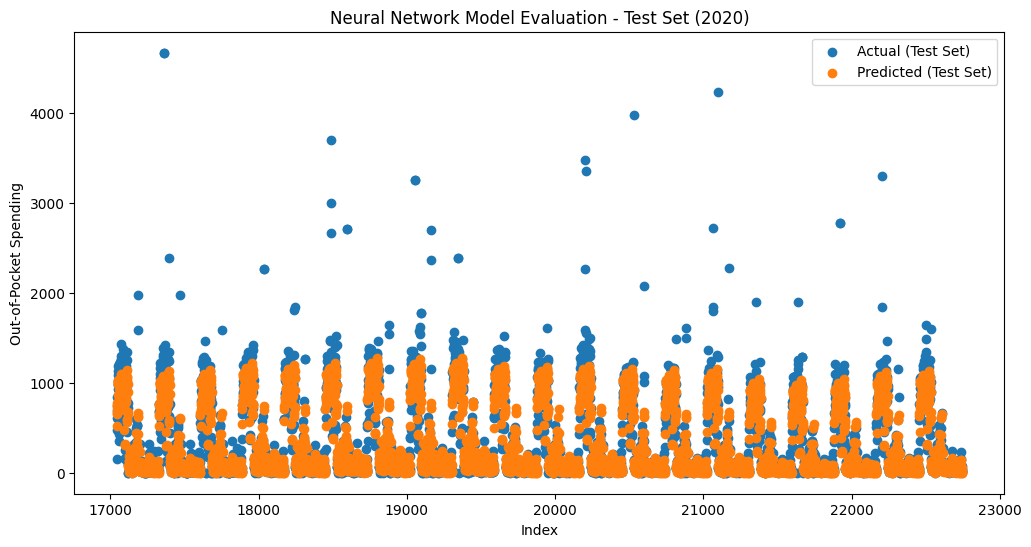

In [68]:
# Line plot for the test set
plt.figure(figsize=(12, 6))
plt.scatter(test_results.index, test_results['Actual'], label='Actual (Test Set)', marker='o')
plt.scatter(test_results.index, test_results['Predicted'], label='Predicted (Test Set)', marker='o')
plt.title('Neural Network Model Evaluation - Test Set (2020)')
plt.xlabel('Index')
plt.ylabel('Out-of-Pocket Spending')
plt.legend()
plt.show()

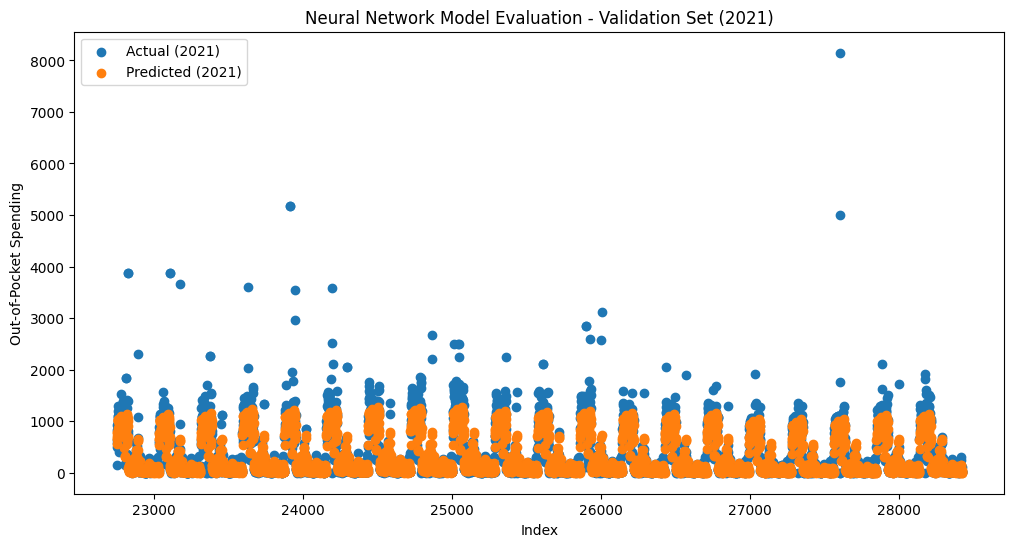

In [69]:
# Line plot for the evaluation set (2021 data)
plt.figure(figsize=(12, 6))
plt.scatter(eval_results.index, eval_results['Actual'], label='Actual (2021)', marker='o')
plt.scatter(eval_results.index, eval_results['Predicted'], label='Predicted (2021)', marker='o')
plt.title('Neural Network Model Evaluation - Validation Set (2021)')
plt.xlabel('Index')
plt.ylabel('Out-of-Pocket Spending')
plt.legend()
plt.show()

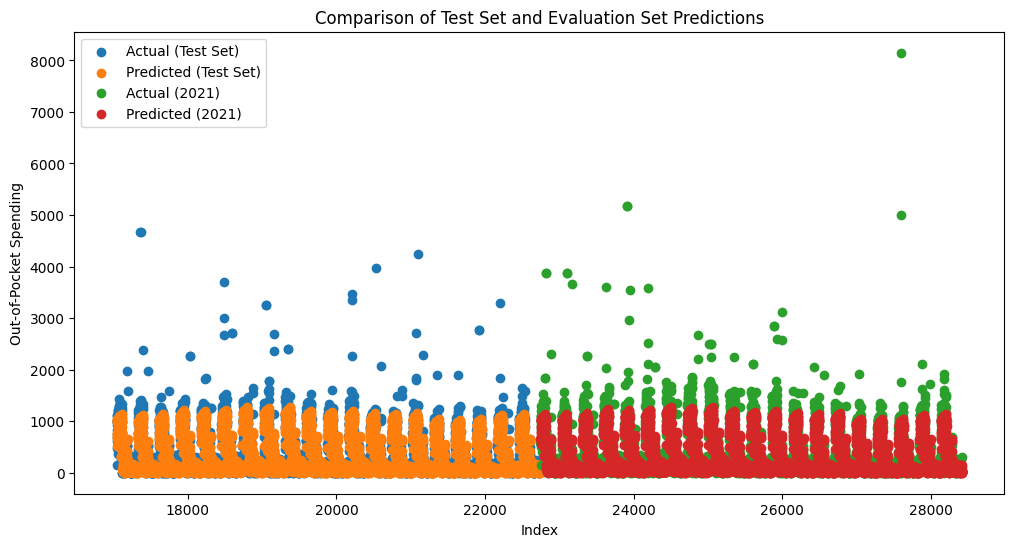

In [70]:
# Combine test and evaluation results for plotting
combined_results = pd.concat([test_results, eval_results])

# Line plot comparing test set and evaluation set predictions
plt.figure(figsize=(12, 6))
plt.scatter(test_results.index, test_results['Actual'], label='Actual (Test Set)', marker='o')
plt.scatter(test_results.index, test_results['Predicted'], label='Predicted (Test Set)', marker='o')
plt.scatter(eval_results.index, eval_results['Actual'], label='Actual (2021)', marker='o')
plt.scatter(eval_results.index, eval_results['Predicted'], label='Predicted (2021)', marker='o')
plt.title('Comparison of Test Set and Evaluation Set Predictions')
plt.xlabel('Index')
plt.ylabel('Out-of-Pocket Spending')
plt.legend()
plt.show()

In [71]:
X_test_df['y_pred_nntest'] = y_pred_nn_test


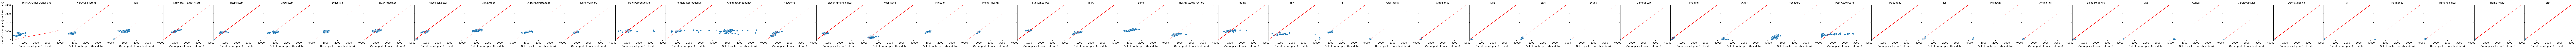

In [72]:
graph_4 = sns.FacetGrid(X_test_df, col = 'hcci_detcat_2_label')
graph_4.map_dataframe(sns.scatterplot,x='y_test_oopprice', y='y_pred_nntest')

for ax in graph_4.axes.flat:
    ax.plot([0, ax.get_xlim()[1]], [0, ax.get_ylim()[1]], color='red', linestyle=':', linewidth=2)

    ax.set_xlim([0,4000])
    ax.set_ylim([0,4000])

graph_4.set_axis_labels('Out of pocket price(test data)','Out of pocket price(predicted data)')
graph_4.set_titles(col_template = '{col_name}')

In [72]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



y_true = [actual_values]
y_pred_linear = [y_pred_linear_values]
y_pred_rf = [y_pred_rf_values]
y_pred_svr = [y_pred_svr_values]
y_pred_nn = [y_pred_nn_values]
# Calculate evaluation metrics for each model
metrics = {
    'Mean Squared Error': [mean_squared_error(y_true, y_pred_linear), mean_squared_error(y_true, y_pred_rf),
                           mean_squared_error(y_true, y_pred_svr), mean_squared_error(y_true, y_pred_nn)],
    'Mean Absolute Error': [mean_absolute_error(y_true, y_pred_linear), mean_absolute_error(y_true, y_pred_rf),
                            mean_absolute_error(y_true, y_pred_svr), mean_absolute_error(y_true, y_pred_nn)],
    'R-squared': [r2_score(y_true, y_pred_linear), r2_score(y_true, y_pred_rf),
                   r2_score(y_true, y_pred_svr), r2_score(y_true, y_pred_nn)]
}

# Create a Pandas DataFrame
data = {
    'Model': ['Linear Regression', 'Random Forest', 'SVR', 'Neural Network'],
    'Mean Squared Error': metrics['Mean Squared Error'],
    'Mean Absolute Error': metrics['Mean Absolute Error'],
    'R-squared': metrics['R-squared']
}

comparison_table = pd.DataFrame(data)

# Print the comparison table
print(comparison_table)